In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.cm as cm  
%matplotlib inline


np.random.seed(7)

from datetime import datetime

#from sklearn.cross_validation import KFold, train_test_split
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#Data pre-processing
# Load the data
train = pd.read_csv("E:/MNIST/digits/fashion-mnist_train.csv")
test = pd.read_csv("E:/MNIST/digits/fashion-mnist_test.csv")

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

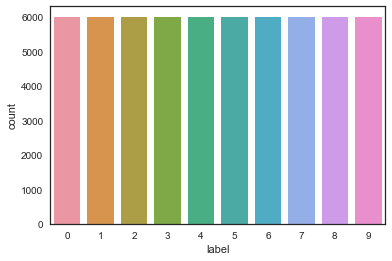

In [3]:
y = train["label"]

# Drop (hapus) column 'label'
X = train.drop(labels = ["label"],axis = 1)
test = test.drop(labels = ["label"],axis = 1)

# # hapus spasi dan ruang
# del train 

g = sns.countplot(y)

y.value_counts()

In [4]:
# Check the data
X.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [6]:
# Set the random seed
random_seed = 7

# Set percentage of test set
test_size = 0.2

In [7]:
# Split the train and the validation set for the fitting
X_train_org, X_val_org, Y_train_org, Y_val_org = train_test_split(X, y, test_size = test_size, random_state=random_seed)

In [8]:
# Normalizsasi the data
X_train = X_train_org / 255.0
X_val = X_val_org / 255.0

test = test / 255.0

In [9]:
# Re-shape image ke dalam 3 dimensi(height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
X_val = X_val.values.reshape(-1,28,28,1)

test = test.values.reshape(-1,28,28,1)

In [10]:
# Encode labels ke hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train_org, num_classes = 10)
Y_val = to_categorical(Y_val_org, num_classes = 10)

In [11]:
print('X_train.shape = ', X_train.shape)
print('Y_train.shape = ', Y_train_org.shape)
print('image_size = ', X.shape[1])
print('image_width = ', X_train.shape[1])
print('image_height = ', X_train.shape[2])
print('labels_count = ', Y_train.shape[1])
print('=' * 50)
print('X_val.shape = ', X_val.shape)
print('Y_val.shape = ', Y_val_org.shape)

def setIdName(x):
    return {0: 'T-shirt/top', 
    1: 'Trouser', 
    2: 'Pullover', 
    3: 'Dress', 
    4: 'Coat',
    5: 'Sandal', 
    6: 'Shirt', 
    7: 'Sneaker', 
    8: 'Bag', 
    9: 'Ankle boot'
    }[x]

X_train.shape =  (48000, 28, 28, 1)
Y_train.shape =  (48000,)
image_size =  784
image_width =  28
image_height =  28
labels_count =  10
X_val.shape =  (12000, 28, 28, 1)
Y_val.shape =  (12000,)


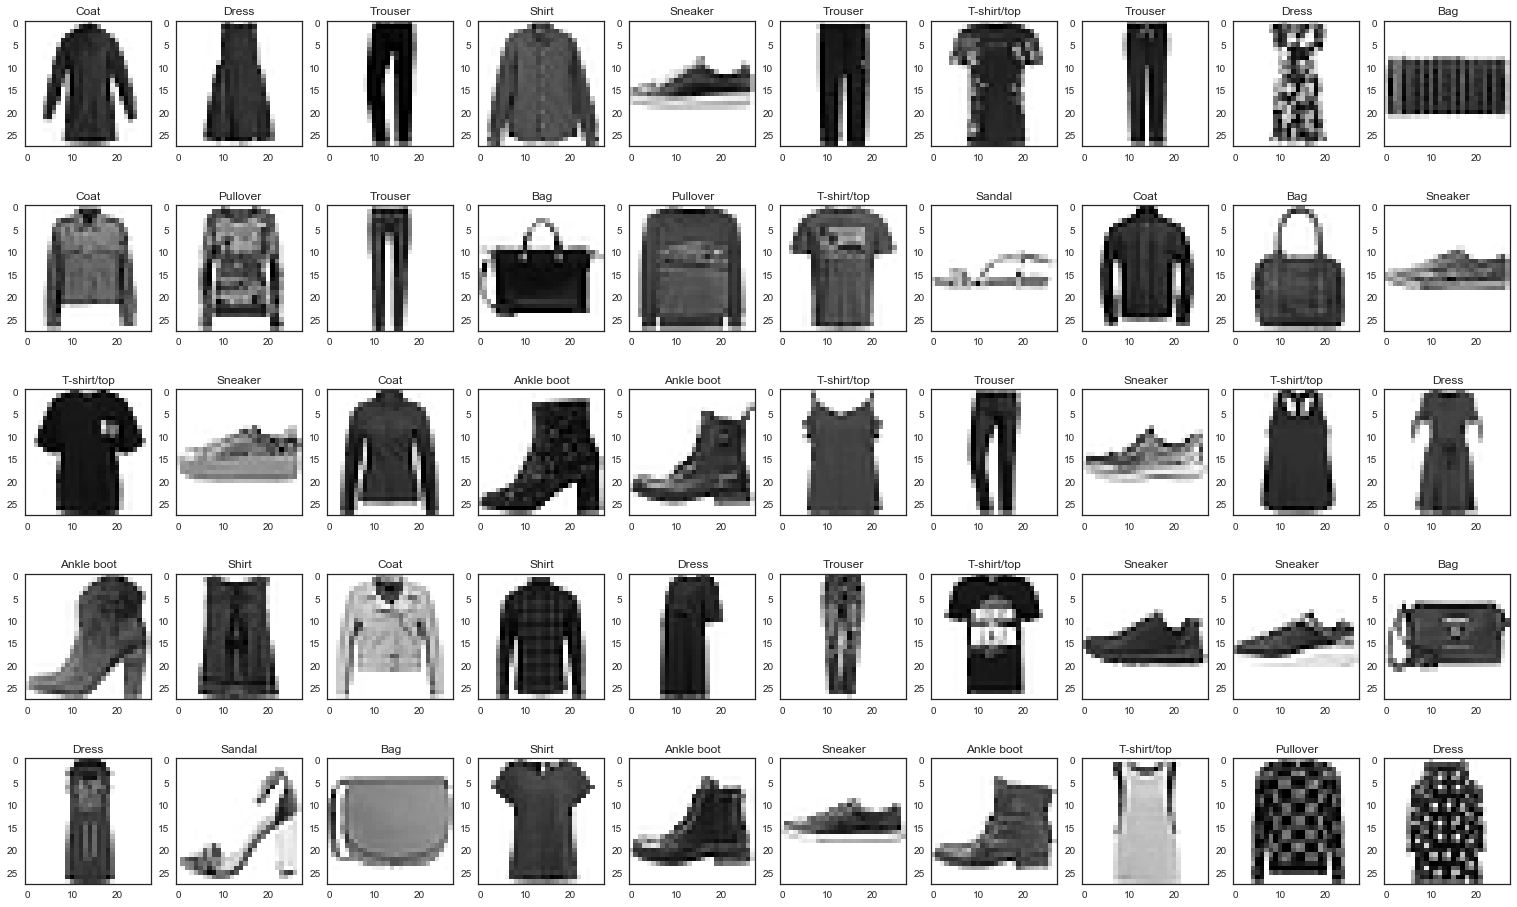

In [12]:
#plot some images and labels
plt.figure(figsize=(15,9))
for i in range(50):
    plt.subplot(5,10,1+i)
    plt.subplots_adjust(right=1.5, top=1.5)
    plt.title(setIdName(np.argmax(Y_train,axis = 1)[i]))
    plt.imshow(X_train[i].reshape(28,28), cmap=cm.binary)

In [13]:
# Set untuk CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [14]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [15]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [16]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [ ]:
epochs = 5 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [ ]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

# With data augmentation to prevent overfitting (accuracy 0.99)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [ ]:
# Fit the model
start = datetime.now()
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
end = datetime.now() - start
train_runtime = str(end.total_seconds()) + ' s'

In [ ]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [ ]:
start = datetime.now()
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
end = datetime.now() - start
test_runtime = str(end.total_seconds()) + ' s'

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

<h2>Mengeluarkan akurasi, precision, dan recall hasil cross validation</h2>

In [ ]:
score = {
    'accuracy' : history.history['val_acc'][-1],
    'precision' : precision_score(Y_true, Y_pred_classes, average='macro'),
    'recall' : recall_score(Y_true, Y_pred_classes, average='macro'),
    'f_score' : f1_score(Y_true, Y_pred_classes, average='macro'),
    'loss' : history.history['val_loss'][-1],
    'train_runtime' : train_runtime,
    'test_runtime' : test_runtime
}

In [ ]:
df_eval = pd.Series(score, index=['accuracy','precision','recall','f_score', 'loss', 'train_runtime', 'test_runtime'])

print (df_eval)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [ ]:
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = list(map(setIdName, list(range(10)))))

In [ ]:
clf_rep = precision_recall_fscore_support(Y_true, Y_pred_classes)
out_dict = {
            "misclassification" : confusion_mtx.sum(axis=1)-confusion_mtx.diagonal()
            ,"accuracy" : (confusion_mtx.diagonal()/confusion_mtx.sum(axis=1)).round(2)
            ,"precision" : clf_rep[0].round(2)
            ,"recall" : clf_rep[1].round(2)
            ,"f1-score" : clf_rep[2].round(2)
            ,"support" : clf_rep[3]
            }
out_df = pd.DataFrame(out_dict)
avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="misclassification" and x.name!="support" else  round(x.sum(), 2)).to_frame().T)
avg_tot.index = ["avg/total"]
out_df = out_df.append(avg_tot)
out_df = out_df.reindex(['misclassification', 'accuracy', 'precision', 'recall', 'f1-score', 'support'], axis=1)
out_df['misclassification'] = out_df['misclassification'].astype('int')
out_df['support'] = out_df['support'].astype('int')

out_df

<h3>Prediksi validation set dengan CNN</h3>

In [ ]:
df_feature = pd.DataFrame(X_val_org)

df_feature = df_feature.reset_index(drop=True)

df_cnn_pred = pd.DataFrame(np.column_stack([Y_true, Y_pred_classes]), columns=['label', 'prediction'])

df_cnn_pred = df_cnn_pred.join(df_feature)

display(df_cnn_pred.head(10))

<h3>Menyimpan hasil prediksi kedalam csv</h3>

In [ ]:
df_cnn_pred.to_csv("cnn_fashion_prediction.csv",index=False)

In [ ]:
y_val_false_index = []

for i in range(Y_true.shape[0]):
    if Y_pred_classes[i] != Y_true[i]:
        y_val_false_index.append(i)

print('# false predictions: ', len(y_val_false_index),'out of', len(Y_true))

plt.figure(figsize=(10,15))
for j in range(0,5):
    for i in range(0,10):
        if j*10+i<len(y_val_false_index):
            plt.subplot(10,10,j*10+i+1)
            plt.subplots_adjust(right=1.5, top=1.5)
            
            # (nilai ground truth) / (nilai prediksi)
            plt.title('%s / %s'%(setIdName(Y_true[y_val_false_index[j*10+i]]),
                               setIdName(Y_pred_classes[y_val_false_index[j*10+i]])))
            plt.imshow(X_val[y_val_false_index[j*10+i]].reshape(28,28),cmap=cm.binary) 